In [1]:
! pip install --upgrade ..  > /dev/null

In [11]:
!tree -h ../data/design_matrix/sample_8_8_50

../data/design_matrix/sample_8_8_50
├── [   0]  _SUCCESS
└── [137M]  part-00000-d61a6293-b977-453f-b82a-938dc69139e8-c000.snappy.parquet

0 directories, 2 files


## Schema

In [12]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


N_CUTS = 8
START_DATE = datetime.strptime("2018-01-01", "%Y-%m-%d")
END_DATE = datetime.strptime("2019-09-01", "%Y-%m-%d")

META = ["partition_id", "title"]
DEGREE = ["degree", "inDegree", "outDegree"]
SIGN = [f"sign_{i}" for i in range(N_CUTS)]
VECTOR = [f"fiedler_{i}" for i in range(N_CUTS)]
DATES = [(START_DATE + timedelta(t)).strftime("%Y-%m-%d")
         for t in range((END_DATE-START_DATE).days)]

SCHEMA = META + DEGREE + SIGN + VECTOR + DATES


data = pd.read_parquet(glob.glob("../data/design_matrix/sample_6_8_50/*.parquet")[0])
pretty_columns = META+DEGREE+SIGN[:1]+VECTOR[:1]+DATES[:3]
data.loc[:, pretty_columns].sample(5)

,partition_id,title,degree,inDegree,outDegree,sign_0,fiedler_0,2018-01-01,2018-01-02,2018-01-03
231969,ooooxoxo,Frank_Hugh_O\'Donnell,469.0,224.0,245.0,False,-4.722178e-10,129.0,136.0,NaN
159034,xooxxooo,Gravedigger_(song),46.0,26.0,20.0,True,1.670113e-10,NaN,NaN,NaN
206473,oxxoooxo,Estadio_Alfredo_Díaz_Angulo,197.0,117.0,80.0,False,-1.825475e-10,NaN,NaN,NaN
59799,ooooxxox,List_of_airworthy_Ju_52s,80.0,33.0,47.0,False,-1.077084e-10,NaN,NaN,NaN
248657,oxxoooxx,Linda_M._McGee,271.0,184.0,87.0,False,-2.123476e-10,148.0,218.0,350.0


# Data preprocessing and plotting

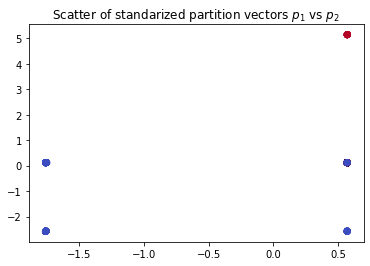

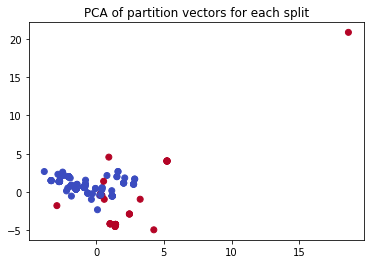

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sample_size = 10**3
sample = data.fillna(0.0).sample(sample_size)

scaler = StandardScaler()
minmax = MinMaxScaler()
pca = PCA(n_components=2)

labels = sample[SIGN[0]].values.astype(int)
z = sample[VECTOR]
z = scaler.fit_transform(z)
G = pca.fit_transform(z)

plt.title("Scatter of standarized partition vectors $p_1$ vs $p_2$")
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="coolwarm")
plt.show()

plt.title("PCA of partition vectors for each split")
plt.scatter(G[:, 0], G[:, 1], c=labels, cmap="coolwarm")
plt.show()

## Gaussian Mixture Model

See [an example of contours with mixture models](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.htmlsphx-glr-auto-examples-mixture-plot-gmm-pdf-py) and [GMM covariances](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)

In [68]:
pd.DataFrame(sample.groupby(by=SIGN[:3]).count()["id"])

id
sign_0 sign_1 sign_2     
False  False  False   174
              True    140
       True   False   121
              True    154
True   False  False   103
              True    103
       True   False   105
              True    100

Note that all of the partitions are evenly spaced by the linear trend of it's cumulative distribution function. We can see that their each of their components are orthgonal by loooking at the inverse covariance matrix. 

CPU times: user 48.1 ms, sys: 13.1 ms, total: 61.1 ms
Wall time: 42.4 ms
(1000, 1000) (8,) (8, 8)


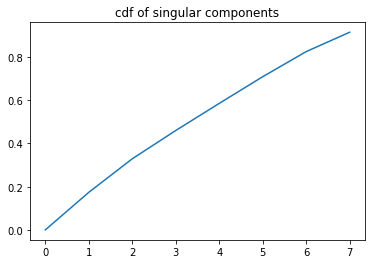

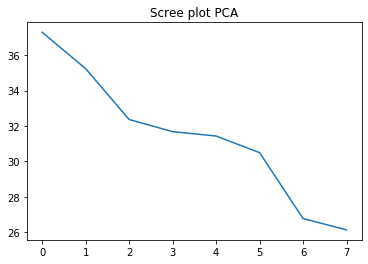

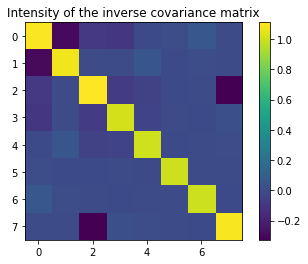

In [69]:
%time u, s, vh = np.linalg.svd(z)
print(u.shape, s.shape, vh.shape)

x = np.arange(s.size)

y = [np.square(s[:k]).sum()/np.square(s).sum() for k in range(s.size)]
plt.title("cdf of singular components")
plt.plot(x, y)
plt.show()

plt.title("Scree plot PCA")
plt.plot(x, s)
plt.show()

precisions = np.linalg.pinv(np.cov(z.T))
plt.title("Intensity of the inverse covariance matrix")
plt.imshow(precisions)
plt.colorbar()
plt.show()

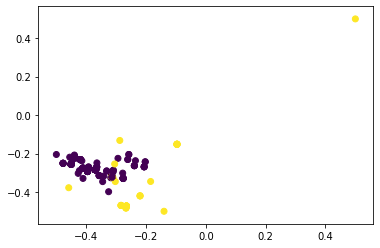

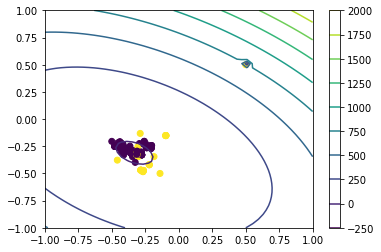

In [77]:
from sklearn.mixture import GaussianMixture

estimator = GaussianMixture(
    n_components=2, 
    tol=0.001, 
    init_params='kmeans',
    covariance_type='full',
)
zz = MinMaxScaler().fit_transform(G)-0.5
estimator.fit(zz[:,:2])

plt.scatter(zz[:,0], zz[:,1], c=labels)
plt.show()

# display predicted scores by the model as a contour plot
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -estimator.score_samples(XX)
Z = Z.reshape(X.shape)

fig = plt.figure()
CS = plt.contour(X, Y, Z)
CB = plt.colorbar(CS)
plt.scatter(zz[:, 0], zz[:, 1], c=labels)
plt.show()

## Logistic Regression

In [78]:
sample[SIGN[0]]

137005     True
180963     True
210527     True
264570    False
95594     False
          ...  
205951     True
268616    False
187881    False
222375    False
23366     False
Name: sign_0, Length: 1000, dtype: bool

In [79]:
G.shape, labels.shape

((1000, 2), (1000,))

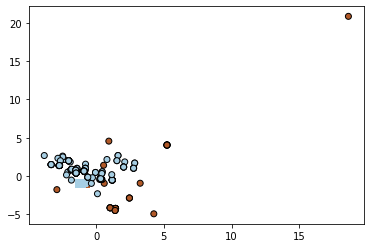

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

logreg = LogisticRegression(solver="newton-cg").fit(G, labels)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired)
plt.scatter(G[:, 0], G[:, 1], c=labels, edgecolors="k", cmap=plt.cm.Paired)

plt.show()